In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys

sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [2]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056


In [3]:
file_path = os.path.join(TS_PREPROC_FOLDER, f'{TRACES}.npy')
traces = np.load(file_path, allow_pickle=True)

traces.shape

(2452, 27, 27)

# RGB format

In [4]:
"""
# array of empty RGB matrixes
rgb_traces = np.zeros((len(traces), traces.shape[1], traces.shape[2], 3), dtype=np.float32)

for i in range(len(traces)):
    trace = traces[i]

    min_value = np.min(trace)
    max_value = np.max(trace)
    normalized_trace = (trace - min_value) / (max_value - min_value)

    red_channel = normalized_trace
    green_channel = np.zeros_like(normalized_trace)
    blue_channel = np.zeros_like(normalized_trace)

    rgb_trace = np.dstack((red_channel, green_channel, blue_channel))
    rgb_traces[i] = rgb_trace


display(rgb_traces.shape)

"""
from PIL import Image

rgb_traces = []

for i in range(len(traces)):
    trace = traces[i]

    min_value = np.min(trace)
    max_value = np.max(trace)
    normalized_trace = (trace - min_value) / (max_value - min_value)

    normalized_trace = (normalized_trace * 255).astype(np.uint8)

    rgb_trace = Image.fromarray(normalized_trace, mode='L').convert('RGB')

    rgb_traces.append(rgb_trace)


rgb_traces = np.array([np.array(trace) for trace in rgb_traces])

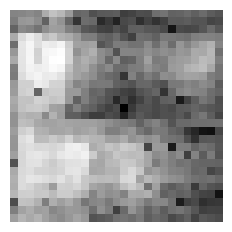

In [5]:
plt.imshow(rgb_traces[0])
plt.axis('off')
plt.show()

# Training, Validation and Test Sets Preparation

In [6]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

rgb_traces

array([[[[132, 132, 132],
         [134, 134, 134],
         [139, 139, 139],
         ...,
         [107, 107, 107],
         [ 92,  92,  92],
         [ 84,  84,  84]],

        [[124, 124, 124],
         [151, 151, 151],
         [154, 154, 154],
         ...,
         [ 84,  84,  84],
         [ 69,  69,  69],
         [ 74,  74,  74]],

        [[ 99,  99,  99],
         [137, 137, 137],
         [130, 130, 130],
         ...,
         [ 86,  86,  86],
         [107, 107, 107],
         [ 87,  87,  87]],

        ...,

        [[ 77,  77,  77],
         [194, 194, 194],
         [192, 192, 192],
         ...,
         [ 47,  47,  47],
         [ 54,  54,  54],
         [ 56,  56,  56]],

        [[127, 127, 127],
         [162, 162, 162],
         [173, 173, 173],
         ...,
         [ 63,  63,  63],
         [ 67,  67,  67],
         [ 66,  66,  66]],

        [[158, 158, 158],
         [180, 180, 180],
         [169, 169, 169],
         ...,
         [ 88,  88,  88],
        

In [7]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = rgb_traces[:split_index]
X_test = rgb_traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

X_train_v, X_valid, y_train_v, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

X_train_v.shape, X_valid.shape, X_test.shape, y_train_v.shape, y_valid.shape, y_test.shape

((1462, 27, 27, 3),
 (366, 27, 27, 3),
 (624, 27, 27, 3),
 (1462,),
 (366,),
 (624,))

# CNN

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_train_v = label_encoder.fit_transform(y_train_v)
y_valid = label_encoder.transform(y_valid)
y_test = label_encoder.transform(y_test)

In [9]:
from keras.src.layers import Conv2D, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Dense
from keras import Sequential


def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):

    model = Sequential()

    model.add(Conv2D(filters=filters,
                     kernel_size=(kernel_size, kernel_size),
                     activation='relu',
                     input_shape=input_shape,
                     padding='same'
                     ))

    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for _ in range(n_conv):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling2D())

    for _ in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [10]:
import optuna
from sklearn.metrics import accuracy_score

# objective function to be minimized
def objective_fun(trial):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)

    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")

    cnn = build_model(X_train_v.shape[1:], len(np.unique(y_train_v)),
                      n_hidden=n_hidden,
                      hidden_nodes=hidden_nodes,
                      n_conv=n_conv,
                      dropout=dropout,
                      filters=filters,
                      kernel_size=kernel_size,
                      )

    cnn.fit(X_train_v, y_train_v, batch_size=batch_size, epochs=epochs, verbose=False)

    y_pred = np.argmax(cnn.predict(X_valid), axis=1)

    error = accuracy_score(y_valid, y_pred)

    return error


study = optuna.create_study(direction='maximize')
study.optimize(objective_fun, n_trials=1, n_jobs=-1, catch=ValueError)

[I 2023-06-29 15:59:26,594] A new study created in memory with name: no-name-f8e361d7-97fb-40a5-958c-0c0685ee9541


Running little bitch having n_conv=1, dropout=0.13348666325984723, hidden_nodes=98
12/12 [==============================] - 0s 12ms/step


[I 2023-06-29 16:01:54,141] Trial 0 finished with value: 0.5136612021857924 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 98, 'dropout': 0.13348666325984723, 'filters': 16, 'kernel_size': 11, 'batch_size': 57, 'epochs': 67}. Best is trial 0 with value: 0.5136612021857924.


In [11]:
best_params = study.best_params
best_params

{'n_conv': 1,
 'n_hidden': 0,
 'hidden_nodes': 98,
 'dropout': 0.13348666325984723,
 'filters': 16,
 'kernel_size': 11,
 'batch_size': 57,
 'epochs': 67}

In [12]:
cnn = build_model(X_train.shape[1:], 2, **best_params)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 16)        5824      
                                                                 
 batch_normalization (Batch  (None, 27, 27, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 27, 27, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 16)        30992     
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 16)        64        
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 27, 27, 16)        0

In [13]:
cnn.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'])

Epoch 1/67
33/33 [==============================] - 3s 88ms/step - loss: 0.7000 - accuracy: 0.5295
Epoch 2/67
33/33 [==============================] - 3s 88ms/step - loss: 0.6907 - accuracy: 0.5284
Epoch 3/67
33/33 [==============================] - 3s 94ms/step - loss: 0.6893 - accuracy: 0.5427
Epoch 4/67
33/33 [==============================] - 3s 88ms/step - loss: 0.6878 - accuracy: 0.5509
Epoch 5/67
33/33 [==============================] - 3s 88ms/step - loss: 0.6865 - accuracy: 0.5525
Epoch 6/67
33/33 [==============================] - 3s 88ms/step - loss: 0.6856 - accuracy: 0.5509
Epoch 7/67
33/33 [==============================] - 3s 88ms/step - loss: 0.6886 - accuracy: 0.5487
Epoch 8/67
33/33 [==============================] - 3s 89ms/step - loss: 0.6859 - accuracy: 0.5372
Epoch 9/67
33/33 [==============================] - 3s 89ms/step - loss: 0.6857 - accuracy: 0.5509
Epoch 10/67
33/33 [==============================] - 3s 89ms/step - loss: 0.6850 - accuracy: 0.5503
Epoch 11/

In [14]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

predictions = cnn.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 14ms/step
Cohen k 0.0064102564102563875
Accuracy 0.5032051282051282
F1-score [0.38      0.5855615]
              precision    recall  f1-score   support

           0       0.51      0.30      0.38       312
           1       0.50      0.70      0.59       312

    accuracy                           0.50       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.50      0.50      0.48       624



# LIME

In [15]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(X_test[0], cnn.predict, top_labels=2)

image, mask = explanation.get_image_and_mask(0, hide_rest=True)
marked_image = mark_boundaries(image, mask)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


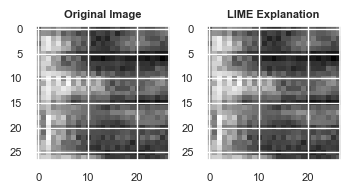

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(X_test[0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(marked_image / 255)
plt.title('LIME Explanation')

plt.show()